In [2]:
# Base import and functions

import imutils
import cv2
from imutils import contours
import os, os.path

from tqdm import tqdm

import pytesseract             # Python interface to tesseract for OCR

import numpy as np
from PIL import Image

from skimage.color import rgb2gray
from skimage.exposure import equalize_adapthist, adjust_log
from skimage.restoration import denoise_tv_chambolle, denoise_wavelet, denoise_bilateral
from skimage.filters import threshold_niblack
from skimage.util import img_as_float, img_as_ubyte, img_as_uint
from skimage.morphology import reconstruction
from skimage.morphology import remove_small_objects, remove_small_holes
from skimage.morphology import disk, diamond, square
from skimage.filters import rank
from skimage.filters import threshold_mean, threshold_local
from skimage.morphology import erosion, dilation, opening, closing, binary_opening, binary_closing, binary_dilation, binary_erosion

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%load_ext line_profiler

import skimage
print("skimage: " + skimage.__version__)  # Must be greater then 0.14 for Chain Vesa

skimage: 0.14dev


## Extremal Region Filter algorithm described in
Neumann L., Matas J.: Real-Time Scene Text Localization and Recognition, CVPR 2012

In [155]:
def crop_number(input_src):
    return input_src[310:310+100, 300:300+330]

def projectionVer(input_img):
    return np.sum(input_img, axis=1)/255

def projectionHor(input_img):
    return np.sum(input_img, axis=0)/255

def threshold(number):
    gray = cv2.cvtColor(number, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.5, tileGridSize=(8,8))

    # C++ code https://stackoverflow.com/questions/24341114/simple-illumination-correction-in-images-opencv-c
    lab_image = cv2.cvtColor(number, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab_image)
    clh2 = clahe.apply(l)
   
    _, trunc = cv2.threshold(clh2, 100, 255, cv2.THRESH_TRUNC)
    trunc = cv2.bilateralFilter(trunc, 6, 25, 25)
    return cv2.adaptiveThreshold(trunc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 5)

In [186]:
def display_single_tests():
    fig, ax = plt.subplots(2, 4, figsize=(40, 5), sharex=True, sharey=True)
    ax = ax.ravel()

    ax[0].imshow(cv2.cvtColor(number, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Original image')
    ax[0].axis('off')

    ax[1].imshow(cv2.cvtColor(thresholded, cv2.COLOR_GRAY2RGB))
    ax[1].set_title('Thresholded')
    ax[1].axis('off')

    ax[2].imshow(cv2.cvtColor(contours, cv2.COLOR_BGR2RGB))
    ax[2].set_title('Contoured')
    ax[2].axis('off')

    ax[3].imshow(cv2.cvtColor(good_mask, cv2.COLOR_GRAY2RGB))
    ax[3].set_title('Good Mask')
    ax[3].axis('off')

    ax[4].imshow(cv2.cvtColor(graphicHor, cv2.COLOR_GRAY2RGB))
    ax[4].set_title('graphicHor')
    ax[4].axis('off')
    
    ax[5].imshow(cv2.cvtColor(graphicVer, cv2.COLOR_GRAY2RGB))
    ax[5].set_title('graphicVer')
    ax[5].axis('off')

    ax[6].imshow(cv2.cvtColor(contours2, cv2.COLOR_BGR2RGB))
    ax[6].set_title('Contoured')
    ax[6].axis('off')

    ax[7].imshow(cv2.cvtColor(source_copy, cv2.COLOR_BGR2RGB))
    ax[7].set_title('')
    ax[7].axis('off')

    #ax[7].imshow(cv2.cvtColor(dilated[tly:rby, tlx:rbx], cv2.COLOR_GRAY2RGB))
    #ax[7].set_title('Number Zone')
    #ax[7].axis('off')

In [187]:
# excise_src = cv2.imread("data/monitor/_1521540786569_capture.png")
# excise_src = cv2.imread("data/monitor/_1521540617554_capture.png")
# excise_src = cv2.imread("data/monitor/_1521540917583_capture.png")

# excise_src = cv2.imread("data/monitor/_1521541525082_capture.png")
# excise_src = cv2.imread("data/monitor/_1521540642840_capture.png")

# excise_src = cv2.imread("data/monitor/_1521540926209_capture.png")
# excise_src = cv2.imread("data/monitor/_1521540643837_capture.png")
excise_src = cv2.imread("data/monitor/_1521540628560_capture.png")
# excise_src = cv2.imread("data/monitor/_1521540613851_capture.png")

Extracting Class Specific Extremal Regions from 9 channels ...
    (...) this may take a while (...)


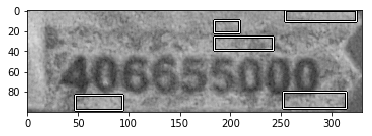

In [208]:
number = crop_number(excise_src)

img      = number
# for visualization
vis      = number.copy()


# Extract channels to be processed individually
channels = cv2.text.computeNMChannels(img)
# Append negative channels to detect ER- (bright regions over dark background)
cn = len(channels)-1
for c in range(0,cn):
  channels.append((255-channels[c]))

# Apply the default cascade classifier to each independent channel (could be done in parallel)
print("Extracting Class Specific Extremal Regions from "+str(len(channels))+" channels ...")
print("    (...) this may take a while (...)")
for channel in channels:

  erc1 = cv2.text.loadClassifierNM1('cv_classifiers/trained_classifierNM1.xml')
  er1 = cv2.text.createERFilterNM1(erc1,16,0.00015,0.13,0.2,True,0.1)

  erc2 = cv2.text.loadClassifierNM2('cv_classifiers/trained_classifierNM2.xml')
  er2 = cv2.text.createERFilterNM2(erc2,0.5)

  regions = cv2.text.detectRegions(channel,er1,er2)

  rects = cv2.text.erGrouping(img,channel,[r.tolist() for r in regions])
  #rects = cv.text.erGrouping(img,channel,[x.tolist() for x in regions], cv.text.ERGROUPING_ORIENTATION_ANY,'../../GSoC2014/opencv_contrib/modules/text/samples/trained_classifier_erGrouping.xml',0.5)

  #Visualization
  for r in range(0,np.shape(rects)[0]):
    rect = rects[r]
    cv2.rectangle(vis, (rect[0],rect[1]), (rect[0]+rect[2],rect[1]+rect[3]), (0, 0, 0), 2)
    cv2.rectangle(vis, (rect[0],rect[1]), (rect[0]+rect[2],rect[1]+rect[3]), (255, 255, 255), 1)

plt.imshow(vis)

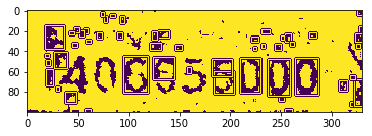

In [197]:
number = crop_number(excise_src)
thresholded = threshold(number)

# for visualization
vis = thresholded.copy()

erc1 = cv2.text.loadClassifierNM1('cv_classifiers/trained_classifierNM1.xml')
er1 = cv2.text.createERFilterNM1(erc1,16,0.00015,0.13,0.2,True,0.1)

erc2 = cv2.text.loadClassifierNM2('cv_classifiers/trained_classifierNM2.xml')
er2 = cv2.text.createERFilterNM2(erc2,0.5)

regions = cv2.text.detectRegions(thresholded,er1,er2)

rects = [cv2.boundingRect(p.reshape(-1, 1, 2)) for p in regions]
#rects = cv2.text.erGrouping(thresholded,thresholded,[r.tolist() for r in regions])
#rects = cv.text.erGrouping(img,channel,[x.tolist() for x in regions], cv.text.ERGROUPING_ORIENTATION_ANY,'../../GSoC2014/opencv_contrib/modules/text/samples/trained_classifier_erGrouping.xml',0.5)

#Visualization
for r in range(0,np.shape(rects)[0]):
    rect = rects[r]
    cv2.rectangle(vis, (rect[0],rect[1]), (rect[0]+rect[2],rect[1]+rect[3]), (0, 0, 0), 2)
    cv2.rectangle(vis, (rect[0],rect[1]), (rect[0]+rect[2],rect[1]+rect[3]), (255, 255, 255), 1)

plt.imshow(vis)

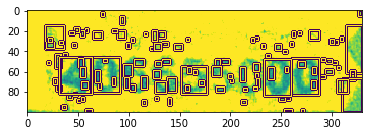

In [200]:
number = crop_number(excise_src)
gray = cv2.cvtColor(number, cv2.COLOR_BGR2GRAY)
kernel = np.matrix([
        [-0.1, 0.1, -0.1],
        [ 0.1,   2,  0.1],
        [-0.1, 0.1, -0.1]
    ])

bright = cv2.filter2D(gray, -1, kernel)

clahe = cv2.createCLAHE(clipLimit=3.5, tileGridSize=(8,8))

# C++ code https://stackoverflow.com/questions/24341114/simple-illumination-correction-in-images-opencv-c
lab_image = cv2.cvtColor(number, cv2.COLOR_RGB2LAB)
l, a, b = cv2.split(lab_image)
clh2 = clahe.apply(l)

_, trunc = cv2.threshold(clh2, 100, 255, cv2.THRESH_TRUNC)
trunc = cv2.bilateralFilter(trunc, 6, 25, 25)
thresholded = cv2.adaptiveThreshold(trunc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 5)

thresholded = bright

# for visualization
vis = thresholded.copy()

erc1 = cv2.text.loadClassifierNM1('cv_classifiers/trained_classifierNM1.xml')
er1 = cv2.text.createERFilterNM1(erc1,16,0.00015,0.13,0.2,True,0.1)

erc2 = cv2.text.loadClassifierNM2('cv_classifiers/trained_classifierNM2.xml')
er2 = cv2.text.createERFilterNM2(erc2,0.5)

regions = cv2.text.detectRegions(thresholded,er1,er2)

rects = [cv2.boundingRect(p.reshape(-1, 1, 2)) for p in regions]
#rects = cv2.text.erGrouping(thresholded,thresholded,[r.tolist() for r in regions])
#rects = cv.text.erGrouping(img,channel,[x.tolist() for x in regions], cv.text.ERGROUPING_ORIENTATION_ANY,'../../GSoC2014/opencv_contrib/modules/text/samples/trained_classifier_erGrouping.xml',0.5)

#Visualization
for r in range(0,np.shape(rects)[0]):
    rect = rects[r]
    cv2.rectangle(vis, (rect[0],rect[1]), (rect[0]+rect[2],rect[1]+rect[3]), (0, 0, 0), 2)
    cv2.rectangle(vis, (rect[0],rect[1]), (rect[0]+rect[2],rect[1]+rect[3]), (255, 255, 255), 1)

plt.imshow(vis)

# Simple Deep Learning text detection
* Minghui Liao et al.: TextBoxes: A Fast Text Detector with a Single Deep Neural Network https://arxiv.org/abs/1611.06779

In [204]:
method_list = [func for func in dir(cv2.text) if callable(getattr(cv2.text, func))]
method_list

['OCRBeamSearchDecoder_create',
 'OCRHMMDecoder_create',
 'OCRTesseract_create',
 'computeNMChannels',
 'createERFilterNM1',
 'createERFilterNM2',
 'createOCRHMMTransitionsTable',
 'detectRegions',
 'erGrouping',
 'loadClassifierNM1',
 'loadClassifierNM2',
 'loadOCRBeamSearchClassifierCNN',
 'loadOCRHMMClassifier',
 'loadOCRHMMClassifierCNN',
 'loadOCRHMMClassifierNM']

In [205]:
number = crop_number(excise_src)
gray = cv2.cvtColor(number, cv2.COLOR_BGR2GRAY)
kernel = np.matrix([
        [-0.1, 0.1, -0.1],
        [ 0.1,   2,  0.1],
        [-0.1, 0.1, -0.1]
    ])

bright = cv2.filter2D(gray, -1, kernel)

clahe = cv2.createCLAHE(clipLimit=3.5, tileGridSize=(8,8))

# C++ code https://stackoverflow.com/questions/24341114/simple-illumination-correction-in-images-opencv-c
lab_image = cv2.cvtColor(number, cv2.COLOR_RGB2LAB)
l, a, b = cv2.split(lab_image)
clh2 = clahe.apply(l)

_, trunc = cv2.threshold(clh2, 100, 255, cv2.THRESH_TRUNC)
trunc = cv2.bilateralFilter(trunc, 6, 25, 25)
thresholded = cv2.adaptiveThreshold(trunc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 5)

thresholded = bright

textSpotter = cv2.text.TextDetectorCNN_create("cv_classifiers/textbox.prototxt", "cv_classifiers/TextBoxes_icdar13.caffemodel")
rects, outProbs = textSpotter.detect(number);
vis = number.copy()
thres = 0.6

for r in range(np.shape(rects)[0]):
    if outProbs[r] > thres:
        rect = rects[r]
        cv2.rectangle(vis, (rect[0],rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (255, 0, 0), 2)
        
plt.imshow(vis)

TypeError: loadOCRHMMClassifierCNN() takes at most 1 argument (2 given)

## As the error showed - you can not use grids on the base API